In [1]:
import os
import comet_ml
import pandas as pd
import numpy as np
import math
import random
import pickle
import xgboost as xgb
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibrationDisplay
# from advanced_models import *
# from tidy_data import *
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
# from comet_ml import Experiment
# from comet_ml.integration.pytorch import log_model

In [2]:
# ##possible plotting function
# linestyles = ['-', '--']
# names=['XGBoost1', 'XGBoost2']
# fpr1, tpr1, thresholds = roc_curve(y1_val, score_prob1)
# fpr2, tpr2, thresholds = roc_curve(y2_val, score_prob2)
# roc_auc1 = auc(fpr1, tpr1)
# roc_auc2 = auc(fpr2, tpr2)
# plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
# plt.plot(fpr2, tpr2, linestyles[1], label=names[1]+', auc='+str(roc_auc2), lw=3)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

In [3]:
# load data filtering out missing values (Nans) for now, although technically xgboost can handle them
data = pd.read_csv('advanced_models_data.csv')
data.dropna(inplace=True)
print(data.isna().sum())

Unnamed: 0           0
ShotType             0
Period               0
GameTime             0
XCoord               0
YCoord               0
isEmptyNet           0
isGoal               0
DistanceToGoal       0
ShootingAngle        0
LastEvent            0
LastEvent_XCoord     0
LastEvent_YCoord     0
TimeLastEvent        0
DistanceLastEvent    0
Rebound              0
AngleChange          0
Speed                0
dtype: int64


### XGBoost with only 2 features: "DistanceToGoal" and "ShootingAngle"

In [4]:
# Various variables
seed=42
feature = ["DistanceToGoal","ShootingAngle"]
label = ["isGoal"]

In [5]:
# Train Val split
train, val = train_test_split(data, test_size=0.2, random_state=seed)
# adjust for shape
X1_train = train[feature].to_numpy().reshape(-1, len(feature))
y1_train = train[label].to_numpy().reshape(-1, 1)
X1_val = val[feature].to_numpy().reshape(-1, len(feature))
y1_val = val[label].to_numpy().reshape(-1, 1)
# make sure shape could be processed by xgboost
print(X1_train.shape, y1_train.shape, X1_val.shape, y1_val.shape)

(301340, 2) (301340, 1) (75335, 2) (75335, 1)


In [6]:
# first xgb model
xgb1_model = xgb.XGBClassifier(objective = "binary:logistic")
xgb1_model.fit(X1_train, y1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
# metrics for 1st model
y1_pred = xgb1_model.predict(X1_val)
score_prob1 = xgb1_model.predict_proba(X1_val)[:,1]
auc_score1 = roc_auc_score(y1_val, score_prob1)
fpr1, tpr1, threshold = roc_curve(y1_val, score_prob1)
roc_auc1 = auc(fpr1, tpr1)
print(auc_score1)

0.7146524203318947


In [8]:
# random model
np.random.seed(seed)
score_prob_random = np.random.uniform(size=len(y1_val))
fpr_random, tpr_random, threshold = roc_curve(y1_val, score_prob_random)
roc_auc_random = auc(fpr_random, tpr_random)

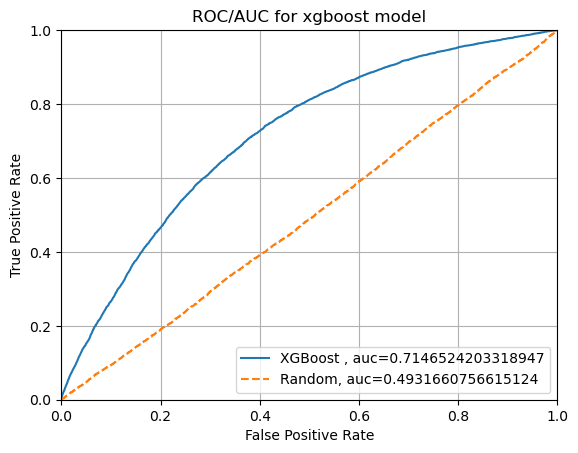

In [9]:
# first curve: ROC/AUC
linestyles = ['-', '--']
names=['XGBoost', 'Random']
plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
plt.plot(fpr_random, tpr_random, linestyles[1], label=names[1]+', auc='+str(roc_auc_random))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC/AUC for xgboost model')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_s/wlt6d82x1tj75q11m6d217gh0000gn/T/ipykernel_6624/156958419.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

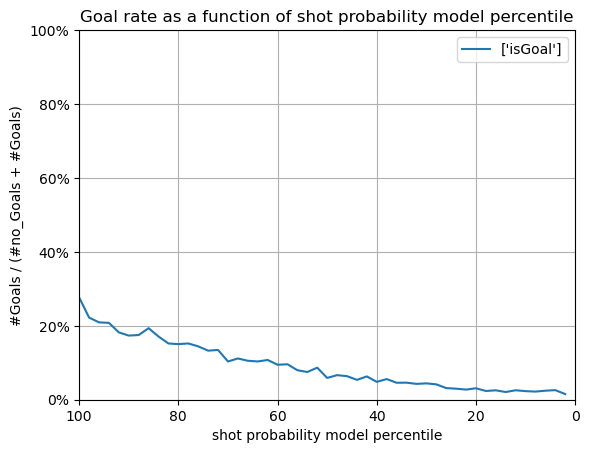

In [10]:
# 2nd curve
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(score_prob1, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y1_val_df = pd.DataFrame(y1_val[:,0])
y1_val_df.rename(columns={ y1_val_df.columns[0]: "isGoal" }, inplace = True)
y1_val_df['percentile_bin'] = pd.cut(score_prob1, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.show()

/var/folders/_s/wlt6d82x1tj75q11m6d217gh0000gn/T/ipykernel_6624/1763412593.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cate

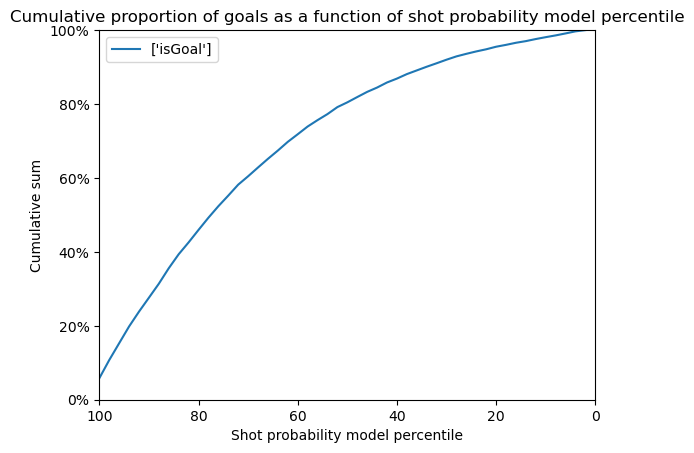

In [11]:
# 3rd curve
number_goal_sum = (y1_val==1).sum()
sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals as a function of shot probability model percentile')
plt.show()

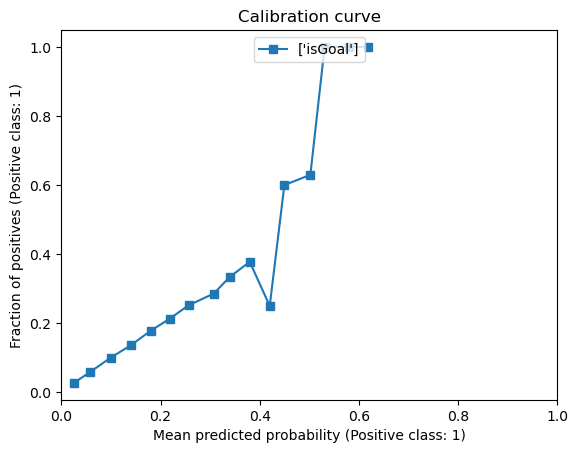

In [12]:
# 4th curve
fig = plt.figure()
ax = plt.axes()
disp = CalibrationDisplay.from_predictions(y1_val, score_prob1, n_bins=25, ax=ax, name=label, ref_line=False)
plt.xlim(0, 1)
plt.legend(loc=9)
plt.title('Calibration curve')
plt.show()

### 2nd XGBoost with HP tuning

In [13]:
data

,Unnamed: 0,ShotType,Period,GameTime,XCoord,YCoord,isEmptyNet,isGoal,DistanceToGoal,ShootingAngle,LastEvent,LastEvent_XCoord,LastEvent_YCoord,TimeLastEvent,DistanceLastEvent,Rebound,AngleChange,Speed
0,3,Wrist Shot,1,00:00:51,-55.0,6.0,0,0,35.0,-80.0,HIT,94.0,-34.0,11.0,154.0,False,0.0,14.000000
1,5,Snap Shot,1,00:01:05,-79.0,0.0,0,0,10.0,0.0,GIVEAWAY,-37.0,-28.0,7.0,50.0,False,0.0,7.142857
2,6,Snap Shot,1,00:01:06,-75.0,-1.0,0,0,14.0,86.0,SHOT,-79.0,0.0,1.0,4.0,True,86.0,4.000000
3,9,Wrist Shot,1,00:01:53,-55.0,-36.0,0,0,50.0,43.0,HIT,-91.0,35.0,18.0,80.0,False,0.0,4.444444
4,15,Tip-In,1,00:02:37,-61.0,-1.0,0,0,28.0,88.0,FACEOFF,-69.0,-22.0,5.0,22.0,False,0.0,4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386779,1623549,Wrist Shot,3,00:17:03,-40.0,18.0,0,0,52.0,-70.0,SHOT,-61.0,0.0,35.0,28.0,True,70.0,0.800000
386780,1623552,Wrist Shot,3,00:17:59,-37.0,22.0,0,0,56.0,-67.0,HIT,-68.0,38.0,16.0,35.0,False,0.0,2.187500
386781,1623553,Slap Shot,3,00:18:07,-59.0,13.0,0,0,33.0,-67.0,SHOT,-37.0,22.0,8.0,24.0,True,0.0,3.000000
386782,1623555,Wrist Shot,3,00:18:16,71.0,-1.0,1,1,18.0,-87.0,FACEOFF,0.0,0.0,0.0,71.0,False,0.0,0.000000


In [14]:
# Excluding 'GameTime' and 'LastEvent' cause not relevant
X2 = data[['ShotType', 'Period', 'XCoord', 'YCoord', 'isEmptyNet',
       'DistanceToGoal', 'ShootingAngle', 'LastEvent_XCoord',
       'LastEvent_YCoord', 'TimeLastEvent', 'DistanceLastEvent', 'Rebound',
       'AngleChange', 'Speed']]
y2 = data['isGoal']

In [15]:
# encoding 'ShotType' column
onehot_E = pd.get_dummies(X2['ShotType'], prefix='ShotType')
X2 = X2.drop('ShotType', axis=1)
X2_OHE = pd.concat([X2, onehot_E], axis=1)

In [16]:
# splitting data
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_OHE, y2, test_size=0.2, random_state=seed)

In [17]:
weight= len(y2[y2 == 1])/len(y2)

In [18]:
# Tuning with GridSearch cross validation for selected hyperparameters
params2 = {
    'gamma' : [0.5, 1.0, 2.0],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}
xgb2_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=weight)
grid_search2 = GridSearchCV(xgb2_model, params2, scoring='roc_auc', cv=3)
grid_search2.fit(X2_train, y2_train)

/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is dep

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0.5, 1.0, 2.0], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [19]:
print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'gamma': 2.0, 'max_depth': 5, 'n_estimators': 100}
0.9987859383443185


In [20]:
# using best HP for 2nd xgb model
xgb2_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', gamma=2.0, max_depth=7, n_estimators=100, scale_pos_weight=weight)
xgb2_model.fit(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
# metrics
y2_pred = xgb2_model.predict(X2_val)
score_prob2 = xgb2_model.predict_proba(X2_val)[:,1]
auc_score2 = roc_auc_score(y2_val, score_prob2)
fpr2, tpr2, thresholds = roc_curve(y2_val, score_prob2)
roc_auc2 = auc(fpr2, tpr2)
print(auc_score2)

0.9986539646813567


/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is dep

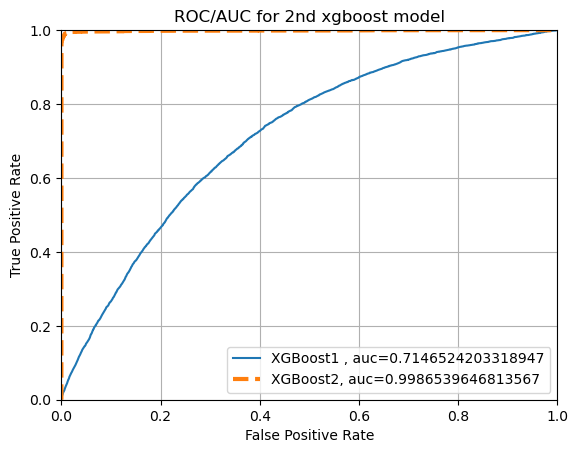

In [22]:
# ROC_AUC curve for 2nd xgboost model
linestyles = ['-', '--']
names=['XGBoost1', 'XGBoost2']
plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
plt.plot(fpr2, tpr2, linestyles[1], label=names[1]+', auc='+str(roc_auc2), lw=3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC/AUC for 2nd xgboost model')
plt.grid(True)
plt.show()

/var/folders/_s/wlt6d82x1tj75q11m6d217gh0000gn/T/ipykernel_6624/265265060.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y2_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

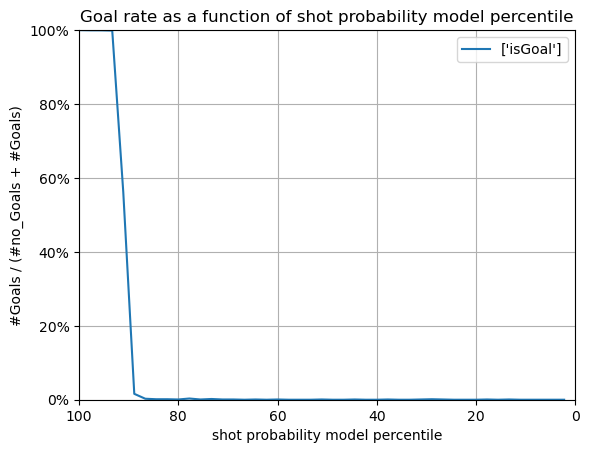

In [23]:
# 2nd curve
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(score_prob2, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y2_val_df = pd.DataFrame(y2_val[:,])
y2_val_df.rename(columns={ y2_val_df.columns[0]: "isGoal" }, inplace = True)
y2_val_df['percentile_bin'] = pd.cut(score_prob2, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y2_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y2_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.show()

/var/folders/_s/wlt6d82x1tj75q11m6d217gh0000gn/T/ipykernel_6624/3230279906.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y2_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cate

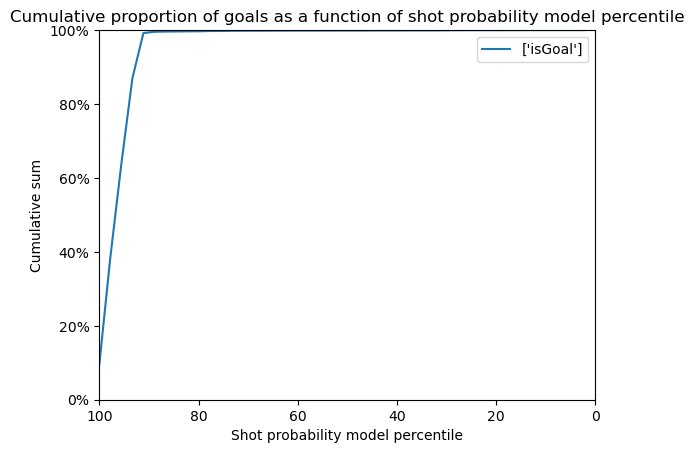

In [24]:
# 3rd curve
number_goal_sum = (y2_val==1).sum()
sum_goals_by_percentile = y2_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y2_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals as a function of shot probability model percentile')
plt.show()

/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


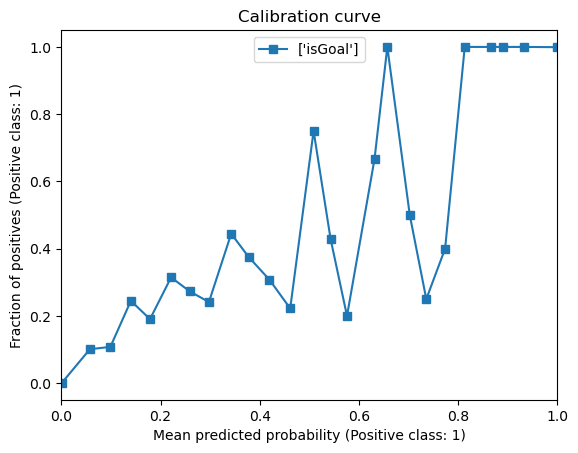

In [25]:
# 4th curve
fig = plt.figure()
ax = plt.axes()
disp = CalibrationDisplay.from_predictions(y2_val, score_prob2, n_bins=25, ax=ax, name=label, ref_line=False)
plt.xlim(0, 1)
plt.legend(loc=9)
plt.title('Calibration curve')
plt.show()

### 3rd xgboost model with feature selection

For our model, since the accuracy is already 99.9%, we will simplify the model by removing some features that are not important. We will use the feature importance from the XGBoost model to determine which features to remove.

In [26]:
# feature importance
all_feature = X2_train.columns
dict_importance = dict(zip(all_feature, xgb2_model.feature_importances_))
sorted_dictImportance = sorted(dict_importance.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_dictImportance[:7]:
    print(f"Feature: {feature}, Importance: {importance}")
rSorted_importances = sorted(dict_importance.items(), key=lambda item: item[1], reverse=False)
# for feature, importance in rSorted_importances[:7]:
#     print(f"Feature: {feature}, Importance: {importance}")

Feature: TimeLastEvent, Importance: 0.5467674136161804
Feature: DistanceLastEvent, Importance: 0.30536091327667236
Feature: LastEvent_XCoord, Importance: 0.03745675086975098
Feature: Period, Importance: 0.03663580119609833
Feature: isEmptyNet, Importance: 0.032754309475421906
Feature: LastEvent_YCoord, Importance: 0.023342512547969818
Feature: Rebound, Importance: 0.006061040796339512


In [27]:
# keeping only the 7 most important features
X3 = X2_OHE[['TimeLastEvent','DistanceLastEvent','LastEvent_XCoord','Period','isEmptyNet']]
y3 = data['isGoal']

In [28]:
X3_train,X3_val,y3_train,y3_val= train_test_split(X3,y3,test_size = 0.2,random_state = seed)

In [29]:
# HP tuning
params3 = {
    'n_estimators': [75, 100, 125],
    'max_depth': [3, 5, 7],
    'gamma': [1.5, 2.0, 2.5],
}
grid_search3 = GridSearchCV(xgb2_model, params3, scoring='roc_auc', cv=3)
grid_search3.fit(X3_train,y3_train)

print(grid_search3.best_score_)

/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is dep

0.9979270727358402


In [30]:
# xgb3 X_train_best,X_val_best,y_train_best,y_val_best
xgb3_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', gamma=2.5, max_depth=7, n_estimators=75, scale_pos_weight=weight)
xgb3_model.fit(X3_train, y3_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# metrics
y3_pred = xgb3_model.predict(X3_val)
score_prob3 = xgb3_model.predict_proba(X3_val)[:,1]
auc_score3 = roc_auc_score(y3_val, score_prob3)
fpr3, tpr3, thresholds = roc_curve(y3_val, score_prob3)
roc_auc3 = auc(fpr3, tpr3)
print(auc_score3)

0.9981344384998404


/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is dep

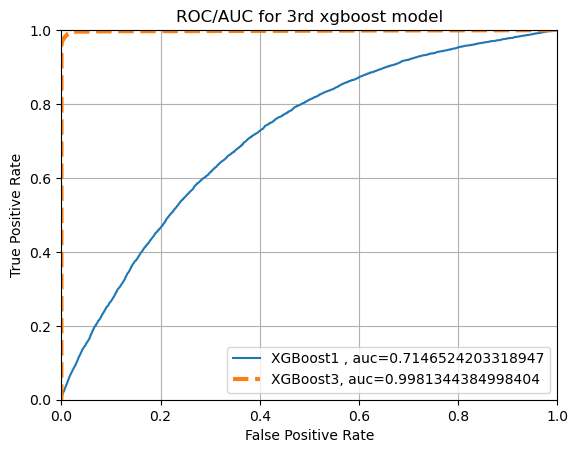

In [32]:
# ROC_AUC curve
linestyles = ['-', '--']
names=['XGBoost1', 'XGBoost3']
plt.plot(fpr1, tpr1, linestyles[0], label=names[0]+' , auc='+str(roc_auc1))
plt.plot(fpr3, tpr3, linestyles[1], label=names[1]+', auc='+str(roc_auc3), lw=3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC/AUC for 3rd xgboost model')
plt.grid(True)
plt.show()

/var/folders/_s/wlt6d82x1tj75q11m6d217gh0000gn/T/ipykernel_6624/2316747627.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y3_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_catego

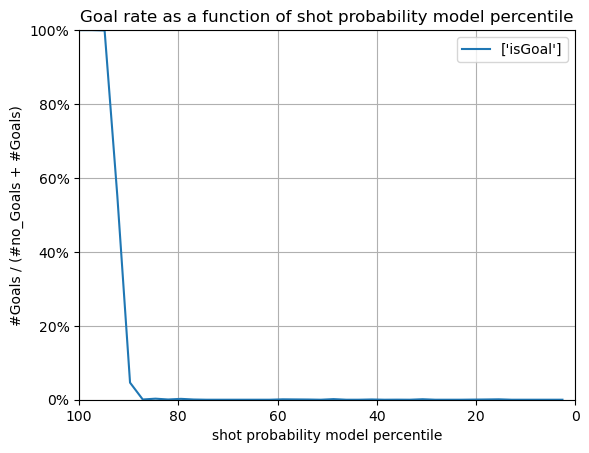

In [33]:
# 2nd curve
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(score_prob3, percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y3_val_df = pd.DataFrame(y3_val[:,])
y3_val_df.rename(columns={ y3_val_df.columns[0]: "isGoal" }, inplace = True)
y3_val_df['percentile_bin'] = pd.cut(score_prob3, pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y3_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y3_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.show()

/var/folders/_s/wlt6d82x1tj75q11m6d217gh0000gn/T/ipykernel_6624/3872772493.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y3_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cate

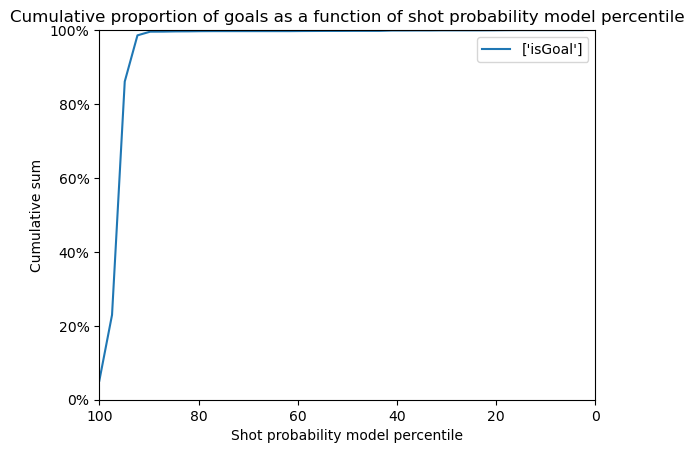

In [34]:
# 3rd curve
number_goal_sum = (y3_val==1).sum()
sum_goals_by_percentile = y3_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y3_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals as a function of shot probability model percentile')
plt.show()

/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tonyzhu/opt/anaconda3/envs/ift6758-conda-env/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


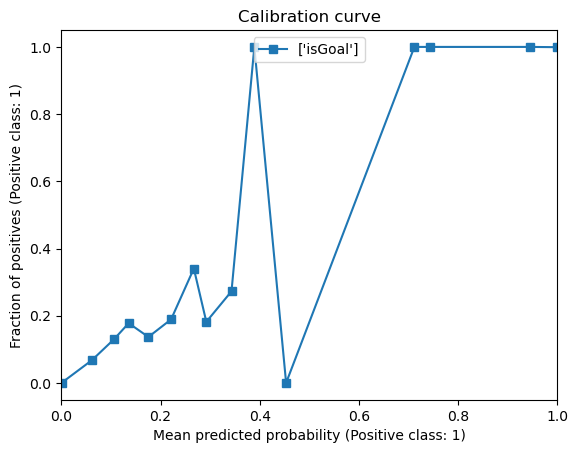

In [35]:
# 4th curve
fig = plt.figure()
ax = plt.axes()
disp = CalibrationDisplay.from_predictions(y3_val, score_prob3, n_bins=25, ax=ax, name=label, ref_line=False)
plt.xlim(0, 1)
plt.legend(loc=9)
plt.title('Calibration curve')
plt.show()